In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# cell_types = []
# sign_map = {'FS':'exc', 'RS':'inh'}
# cell_idxs = np.arange(len(cell_table))
# for c_idx in cell_idxs:#[-k:]:
#     c_type = ''
#     c_type += sign_map[cell_table.RSFS.values[c_idx]] + '_'
#     c_type += cell_table.structure.values[c_idx] + '_'
#     if str.startswith(cell_table.structure.values[c_idx],'VIS'):
#         if cell_table.depth.values[c_idx] > -920:
#             c_type += '1'
#         elif cell_table.depth.values[c_idx] > -960:
#             c_type += '4'
#         else:
#             c_type += '5'
#     cell_types.append(c_type)

# np.savez('cell_types71',cell_types=cell_types)

D = np.load('cell_types71.npz')
cell_types = D['cell_types']

print len(cell_types), np.unique(cell_types)

71 ['exc_VISp_1' 'exc_VISp_5' 'inh_VISp_1' 'inh_VISp_4' 'inh_VISp_5']


In [3]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Add,add, Maximum, Layer, Dense, Lambda
from keras import Sequential
from keras.regularizers import Regularizer
from keras.initializers import RandomUniform
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from scipy.special import gamma
from scipy.stats import pearsonr
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


0.970670612248924


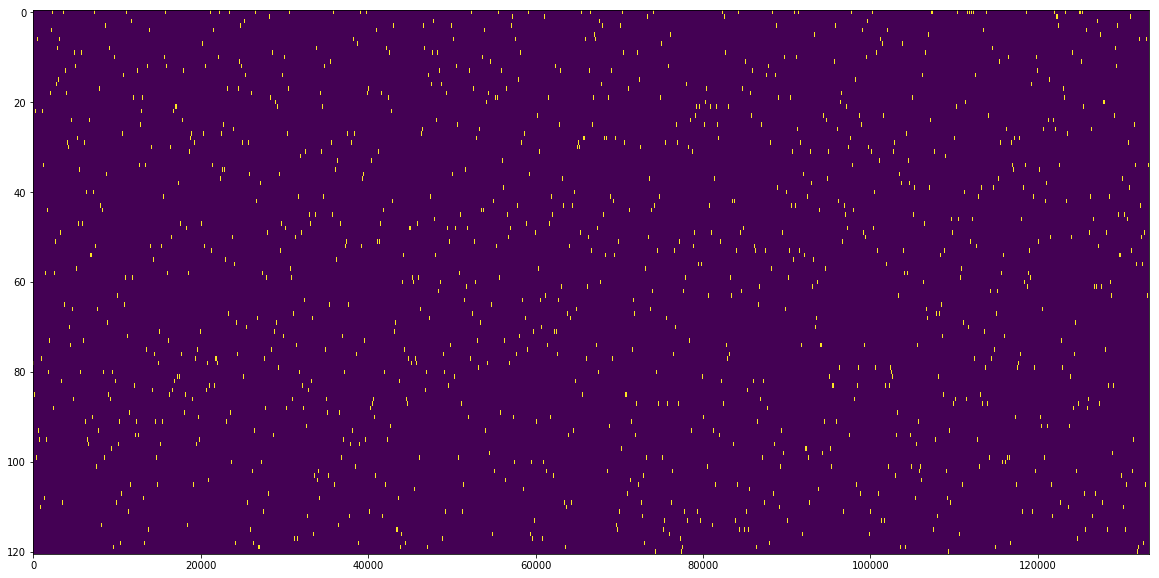

In [4]:
#gratings data

# D = np.load('drifting_gratings_data.npz')
D = np.load('static_gratings_data_4ms.npz')

binned_spikes = D['binned_spikes']
stim = D['stim_array']
CCmaxs = D['CCmaxs']
bin_len = D['bin_len'] #0.01

ord_idxs = np.argsort(CCmaxs)[-30:]
print CCmaxs[ord_idxs[-1]]

conds = np.unique(stim,axis=1)  
mod_stim = np.zeros((conds.shape[1],stim.shape[1]))
for t in range(stim.shape[1]):
    ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
    mod_stim[ind,t] = 1

### sinusoidal encoding for drifiting gratings
# K = 3 # number of harmonics
# L = 2*K+1
# conds = np.unique(stim,axis=1)  
# mod_stim_sin = np.zeros((L*(conds.shape[1]-1),stim.shape[1]))
# ind_old = -1
# for t in range(stim.shape[1]):
#     if stim[0,t]>0:
#         ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
#         if ind!=ind_old:
#             t0=t
#             ind_old=ind
#         mod_stim_sin[(ind-1)*L,t] = 1
#         for k in range(K):
#             mod_stim_sin[(ind-1)*L+2*k+1,t] = np.cos(2.0*np.pi*(k+1)*stim[0,t]*(t-t0)*bin_len)
#             mod_stim_sin[(ind-1)*L+2*k+2,t] = np.sin(2.0*np.pi*(k+1)*stim[0,t]*(t-t0)*bin_len)
        
#     else:
#         ind_old = -1

m_val = mod_stim[:,int(3220/bin_len):]
fig,ax = plt.subplots()
ax.imshow(m_val)
ax.axis('tight')
fig.set_size_inches(20,10)

In [111]:
#video data (natural movie)
D = np.load('movie_data.npz')
binned_spikes = D['binned_spikes']
stim = D['stim_array']
# stim = stim-np.mean(stim,axis=1,keepdims=True)
# stim = (np.linalg.inv(stim.dot(stim.T))).dot(stim)
bin_len = D['bin_len'] 
print stim.shape


(800, 60050)


In [ ]:

nr,nc = 9,8
fig,axes = plt.subplots(nrows=nr,ncols=nc)
d_sta = 20
mod_stims = []
for i in range(binned_spikes.shape[0]):
    mod_stim = 0
    for t in range(d_sta):
        shift_stim = np.concatenate((np.zeros((stim.shape[0],t)),stim[:,:stim.shape[1]-t]),axis=1)
        STA = np.dot(shift_stim,binned_spikes[i,:])/(np.sum(binned_spikes[i,:])+1e-8)
        mod_stim += np.dot(shift_stim.T,STA)
        if t==0:
            ax = axes[i/nc,i%nc]
            m = max(np.max(np.max(STA)),-np.min(np.min(STA)))
            im = ax.imshow(STA.reshape(20,40),cmap='PiYG',vmin=-m,vmax=m)
            ax.set_title(i)
    mod_stims.append(mod_stim)
    
print stim.shape
mod_stim = np.array(mod_stims)
print mod_stim.shape

fig.tight_layout()
fig.set_size_inches(12,10)

(800, 60050)
(71, 60050)


/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


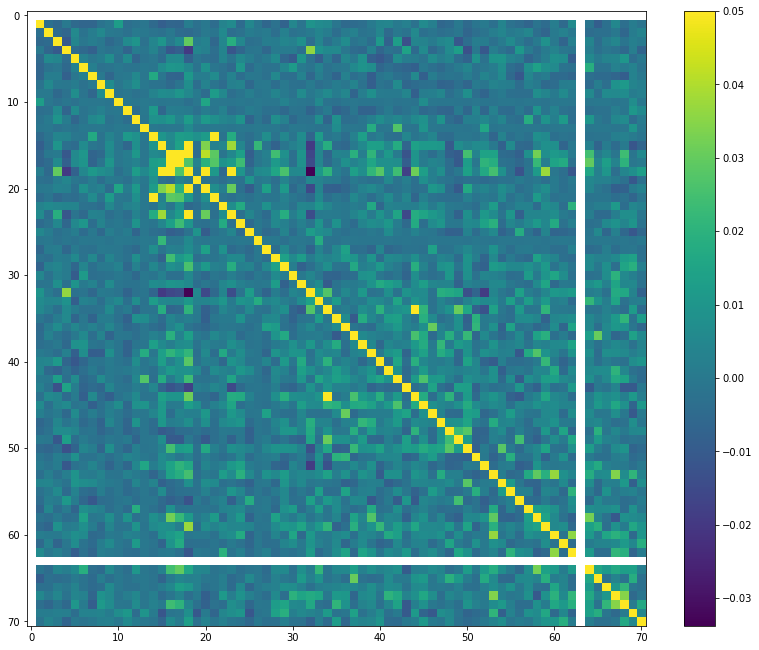

In [5]:

fig,ax = plt.subplots()
im = ax.imshow(np.corrcoef(binned_spikes),vmax=0.05)
ax.axis('tight')
fig.tight_layout()
fig.set_size_inches(12,10)
fig.colorbar(im)

6749.0


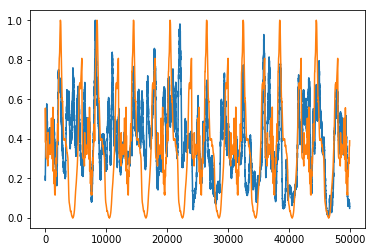

In [6]:
i = 3
print np.sum(binned_spikes[i,:])
t_filt = np.arange(-200,201)
sig = 80
filt = np.exp(-np.square(t_filt)/(sig**2*2))
filt = filt/np.sum(filt)
smoothed_spikes = np.convolve(binned_spikes[i,:],filt,mode='same')
plt.plot(smoothed_spikes[:50000]/np.max(smoothed_spikes))
plt.plot((mod_stims[i][:50000]-np.min(mod_stims[i]))/(np.max(mod_stims[i])-np.min(mod_stims[i])))


In [5]:
# np.savez('movie_data_sta',binned_spikes=binned_spikes, mod_stim=mod_stim)
D = np.load('movie_data_sta.npz')
binned_spikes = D['binned_spikes']
mod_stim = D['mod_stim']

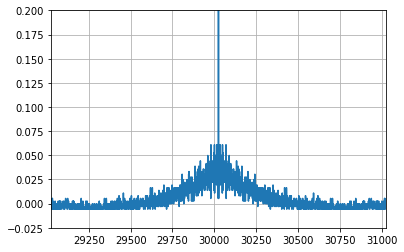

In [9]:
x = binned_spikes[17,:].squeeze()
x=x-np.mean(x)
xc = np.convolve(x,np.flip(x,0),mode='same')
plt.plot(xc/np.max(xc))
plt.ylim([-0.025,0.2])
plt.xlim([30025-1000,30025+1000])
plt.grid()

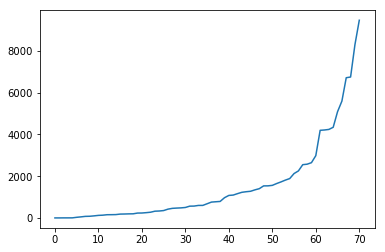

In [6]:
ord_idxs = np.argsort(np.sum(binned_spikes,axis=1))
plt.plot(np.sort(np.sum(binned_spikes,axis=1)))
ord_idxs = ord_idxs[-30:]

In [5]:
### train/val splits
T = binned_spikes.shape[1]

### drifting gratings
# train_inds = np.concatenate((np.arange(int(600/bin_len)),np.arange(int(1600/bin_len),1+int(2200/bin_len))))
# val_inds = np.arange(int(3200/bin_len),T)

### static gratings
# train_inds = np.concatenate((np.arange(int(480/bin_len)),np.arange(int(1800/bin_len),int(2280/bin_len))))
# val_inds = np.arange(int(3220/bin_len),T)

### nat movie
train_inds = np.arange(46700)
val_inds = np.arange(46800,T)

In [135]:
# individual parameter sets
import threading
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

@threadsafe_generator
def batch_generator(flat_stimulus, binned_spikes, inds, d, batch_size=5000):
    d1,d2 = d
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
    T = inds.size
    k=0
    while True:
        idxs = np.arange(k,min(k+batch_size,T))
        y = binned_spikes[inds[idxs]]
        X = np.empty((M*d1+d2,idxs.size))
        for i,idx in enumerate(idxs):
            X[:M*d1,i] = np.fliplr(np.reshape(flat_stimulus[:,inds[idx]-d1:inds[idx]],[1,-1]))
            X[M*d1:,i] = np.fliplr(np.reshape(binned_spikes[inds[idx]-d2:inds[idx]],[1,-1]))
        k = k+batch_size
        if k>T:
            k=0
        yield X.T, y

        
        
def exp_decay(t):
    initial_lrate = 3e-3
    k = 0.95
    lrate = max(initial_lrate * k**t,2e-5)
    return lrate



def corrcoef(x,y):
    xmean = np.mean(x)
    ymean = np.mean(x)
    cov = np.mean((x-xmean)*(y-ymean))
    return cov/(np.std(x)*np.std(y))

# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d: length of filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')

def GLM_indiv_fit(stimulus,spikes,d,bin_len,train_inds,val_inds,f='exp',shared_stim=True, init_sta=True):    
    N = spikes.shape[0]
    T = spikes.shape[1]
    M = stimulus.shape[0]

    bs = 3001
    dmax = max(d)
    spikes = np.concatenate((np.zeros((N,dmax)),spikes),axis=1)
    stimulus = np.concatenate((np.zeros((M,dmax)),stimulus),axis=1)
    train_inds = np.array(train_inds) + dmax
    val_inds = np.array(val_inds) + dmax
    
    F = np.empty((N,M,d[0])) # stimulus filters
    W = np.empty((N,d[1]))  # spike train filters
    b = np.empty((N,)) # biases
    train_losses = np.empty((N,))
    train_corrs = np.empty((N,))
    val_losses = np.empty((N,))
    val_corrs = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    t_filt = np.arange(-6,7)
    sig = 1.5
    filt = np.exp(-np.square(t_filt)/(sig**2*2))
    filt = filt/np.sum(filt)
    
    for i in range(N):
        print i
        
        if shared_stim:
            stim = stimulus
        else:
            stim = stimulus[i:i+1,:]
            M=1
        smoothed_spikes = np.convolve(spikes[i,:],filt,mode='same')
        
        # construct GLM model and return fit
        model = Sequential()
        model.add(Dense(1,input_dim = M*d[0]+d[1],use_bias=True,kernel_initializer=RandomUniform()))
        model.add(Lambda(lambda x: fs[f](x)*bin_len))
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=3e-3))
        if init_sta:
            sta = np.empty((M*d[0]+d[1],1))
            for t in range(d[0]):
                shift_stim = np.concatenate((np.zeros((stim.shape[0],t)),stim[:,:stim.shape[1]-t]),axis=1)
                for m in range(M):
                    sta[m*d[0]+t] = np.dot(shift_stim[m,:],spikes[i,:])/(np.sum(spikes[i,:])+1e-8)
            for t in range(d[1]):
                shift_spks = np.concatenate((np.zeros((t,)),spikes[i,:spikes.shape[1]-t]))
                sta[M*d[0]+t] = np.dot(shift_spks,spikes[i,:])/(np.sum(spikes[i,:])+1e-8)
            model.layers[0].set_weights((sta/50.0,np.array([-0.0001])))
        train_gen = batch_generator(stim,spikes[i,:],train_inds, d,batch_size=bs)
        model.fit_generator(generator = train_gen, 
                            steps_per_epoch = train_inds.size/bs+1,
                            epochs=400,verbose=2,callbacks=[ReduceLROnPlateau(monitor='loss',min_delta=5e-5,patience=1,factor=0.6,min_lr=1e-5,verbose=1), EarlyStopping(monitor='loss',min_delta=1e-5,patience=10)])
        val_gen = batch_generator(stim,spikes[i,:],val_inds, d,batch_size=bs)
#         all_gen = batch_generator(stimulus,spikes[i,:],np.arange(dmax,T+dmax),d,batch_size = bs)
#         pred = model.predict_generator(all_gen,steps=T/bs).squeeze()
#         plt.plot(smoothed_spikes[i,train_inds],pred[train_inds-d[1]],'b,')
#         plt.plot(smoothed_spikes[i,val_inds],pred[val_inds-d[1]],'r,')
#         plt.plot(spikes[i,:200])
#         plt.plot(smoothed_spikes[:200])
#         plt.plot(pred[:200])
        
        all_gen = batch_generator(stim,spikes[i,:],np.arange(dmax,T+dmax),d,batch_size = T)
        pred = model.predict_generator(all_gen,steps=2).squeeze()
        p = model.get_weights()[0]
        F[i,:,:] = p[:M*d[0]].reshape((M,d[0]))
        W[i,:] = np.squeeze(p[M*d[0]:])
        b[i] = model.get_weights()[1]
        train_losses[i] = model.evaluate_generator(train_gen,steps=train_inds.size/bs)
        train_corrs[i] = pearsonr(smoothed_spikes[train_inds],pred[train_inds-dmax])[0]
        val_losses[i] = model.evaluate_generator(val_gen,steps=val_inds.size/bs)
        val_corrs[i] = pearsonr(smoothed_spikes[val_inds],pred[val_inds-dmax])[0]
        
        models.append(model)
    return (F,W,b,train_losses,val_losses,train_corrs,val_corrs,models)


In [139]:
d=[1,30]
# d = [int(2/bin_len),30]

(F,W,b,train_losses,val_losses,train_corrs,val_corrs,models) = GLM_indiv_fit(stim,binned_spikes[ord_idxs[-2:-1],:],d, bin_len,train_inds,val_inds, init_sta=True)
# (F,W,b,train_losses,val_losses,train_corrs,val_corrs,models) = GLM_indiv_fit(mod_stim[ord_idxs,:],binned_spikes[ord_idxs,:],d, bin_len,train_inds,val_inds,shared_stim=False,init_sta=False)


0
Epoch 1/400
 - 3s - loss: 0.4108
Epoch 2/400
 - 1s - loss: 0.3929
Epoch 3/400
 - 1s - loss: 0.3893
Epoch 4/400
 - 1s - loss: 0.3870
Epoch 5/400
 - 1s - loss: 0.3860
Epoch 6/400
 - 1s - loss: 0.3856
Epoch 7/400
 - 1s - loss: 0.3854
Epoch 8/400
 - 1s - loss: 0.3852
Epoch 9/400
 - 1s - loss: 0.3849
Epoch 10/400
 - 1s - loss: 0.3845
Epoch 11/400
 - 1s - loss: 0.3841
Epoch 12/400
 - 1s - loss: 0.3838
Epoch 13/400
 - 1s - loss: 0.3835
Epoch 14/400
 - 1s - loss: 0.3832
Epoch 15/400
 - 1s - loss: 0.3830
Epoch 16/400
 - 1s - loss: 0.3828
Epoch 17/400
 - 1s - loss: 0.3827
Epoch 18/400
 - 1s - loss: 0.3826
Epoch 19/400
 - 1s - loss: 0.3825
Epoch 20/400
 - 1s - loss: 0.3825
Epoch 21/400
 - 1s - loss: 0.3824
Epoch 22/400
 - 1s - loss: 0.3823
Epoch 23/400
 - 1s - loss: 0.3823
Epoch 24/400
 - 1s - loss: 0.3822
Epoch 25/400
 - 1s - loss: 0.3822
Epoch 26/400
 - 1s - loss: 0.3821

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.00180000001565.
Epoch 27/400
 - 1s - loss: 0.3818
Epoch 28/400


In [23]:
np.savez('movie_indivfit2',train_losses=train_losses,val_losses=val_losses,train_corrs=train_corrs,val_corrs=val_corrs,W=W,F=F)


(-1.5, 31.5, -0.6245091021060943, 0.36529732346534727)

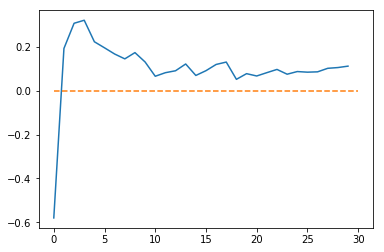

In [140]:
plt.plot(W[:,:].T)
plt.plot([0,30],[0,0],'--')
plt.axis('tight')

(1, 800, 1)


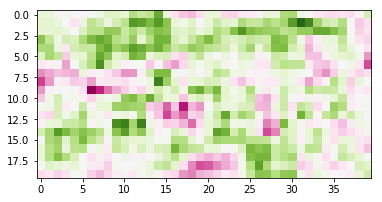

In [144]:
m = max(np.max(np.max(F)),-np.min(np.min(F)))
plt.imshow(F.reshape(20,40),cmap='PiYG',vmin=-m,vmax=m)
print F.shape

In [142]:
np.savez('init_sta_exF',F=F)

(-0.5, 7.5, 4.5, -0.5)

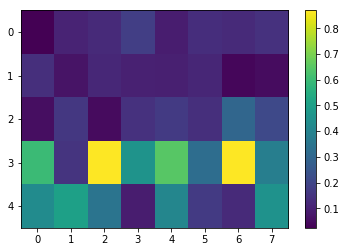

In [241]:
plt.imshow(np.sqrt(F.squeeze()[4::7]**2+F.squeeze()[5::7]**2).reshape(5,8))#,cmap='PiYG',vmin=-0.2,vmax=0.2)
# plt.imshow(F.squeeze()[6::7].reshape(5,8),cmap='PiYG',vmin=-0.2,vmax=0.2)
plt.colorbar()
plt.axis('tight')

(-0.05, 1.05, -0.05, 1.05)

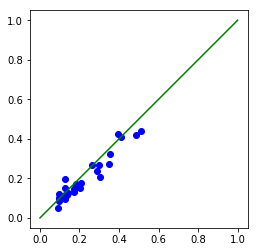

In [71]:
# D = np.load('drifting_gratings_indivfit3.npz')
# print np.argmax(val_corrs)
lims = [0,1]
plt.plot(train_losses,val_losses,'bo',lims,lims,'g')
# plt.plot(D['train_corrs'],train_corrs,'bo',lims,lims,'g')
plt.axis('square')

In [68]:
#parameter sets shared across predefined classes

@threadsafe_generator
def batch_generator_shared(flat_stimulus, binned_spikes,inds, d,neuron=None, batch_size=5000):
    (M,_) = flat_stimulus.shape # M is the size of a stimulus
    (N,_) = binned_spikes.shape
    T = inds.size
    d1,d2 = d
    if len(binned_spikes.shape)==1:
        binned_spikes = np.expand_dims(binned_spikes,0)
    k=0
    if neuron is None:
        neur = 0
    else:
        neur = neuron
    while True:
        idxs = np.arange(k,min(k+batch_size,T))
        y = binned_spikes[neur,inds[idxs]]
        X = np.empty((M*d1+d2+2,idxs.size))
        for i,idx in enumerate(idxs):
            X[:M*d1,i] = np.fliplr(np.reshape(flat_stimulus[:,inds[idx]-d1:inds[idx]],[1,-1]))
            X[M*d1,i] = 1
            X[M*d1+1:-1,i] = np.fliplr(np.reshape(binned_spikes[neur,inds[idx]-d2:inds[idx]],[1,-1]))
            X[-1,i] = neur
        k = k+batch_size
        if k>T:
            k=0
            if neuron is None:
                neur+=1
                if neur==N:
                    neur = 0
        yield X.T, y


class GatedDense(Layer):

    def __init__(self, neuron, output_dim, **kwargs):
        self.neuron = neuron
        self.output_dim = output_dim
        super(GatedDense, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.output_dim, 1), initializer=RandomUniform(minval=-0.01,maxval=0.01),
                                      trainable=True)
        super(GatedDense, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.expand_dims(K.switch(K.equal(float(self.neuron),x[:,-1]),K.squeeze(K.dot(x[:,:self.output_dim],self.kernel),1),K.zeros_like(x[:,-1])))


    def compute_output_shape(self, input_shape):
        return (input_shape[0],1)

def exp_decay(t):
    initial_lrate = 4e-4
    k = 0.97
    lrate = initial_lrate * k**t
    return lrate


# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d: length of filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')

def GLM_shared_fit(stimulus,spikes,d,bin_len,train_inds,val_inds,f='exp',cell_types=None):    
    N = spikes.shape[0]
    T = spikes.shape[1]
    M = stimulus.shape[0]

    bs = 3001
    
    dmax = max(d)
    spikes = np.concatenate((np.zeros((N,dmax)),spikes),axis=1)
    stimulus = np.concatenate((np.zeros((M,dmax)),stimulus),axis=1)
    train_inds = np.array(train_inds)+dmax
    val_inds = np.array(val_inds)+dmax
    
    if cell_types is None:
        cell_types = np.zeros((N,))
    classes = np.unique(cell_types)
    
    F = np.empty((N,M,d[0])) # stimulus filters
    W = {}
    b = np.empty((N,)) # biases
    train_losses = np.empty((N,))
    train_corrs = np.empty((N,))
    val_losses = np.empty((N,))
    val_corrs = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    
    t_filt = np.arange(-6,7)
    sig = 1.5
    filt = np.exp(-np.square(t_filt)/(sig**2*2))
    filt = filt/np.sum(filt)
    
    for cls in classes:
        
        # construct GLM model and return fit
        cls_idxs = np.squeeze(np.argwhere(cell_types==cls))
        cls_spikes = spikes[cls_idxs,:]
        print cls, cls_idxs.size
        inp = Input(shape = (M*d[0]+d[1]+2,))
        x = []
        for idx in range(cls_idxs.size):
            x.append(GatedDense(idx,M*d[0]+1)(inp))
        a = Lambda(lambda val: val[:,M*d[0]+1:-1])(inp)
        x.append(Dense(1,use_bias=False)(a))
        x = Add()(x)
        out = Lambda(lambda val: fs[f](val)*bin_len)(x)
        model = Model(inputs=[inp],outputs=[out])
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=1e-3))
        train_gen = batch_generator_shared(stimulus,cls_spikes,train_inds, d,batch_size=bs)
        model.fit_generator(generator = train_gen, 
                            steps_per_epoch = (train_inds.size/bs+1)*cls_idxs.size,
                            epochs=300,verbose=2,
                            callbacks=[LearningRateScheduler(exp_decay),EarlyStopping(monitor='loss',min_delta=1e-5,patience=10)])
#                             callbacks=[ReduceLROnPlateau(monitor='loss',min_delta=1e-4,patience=0,factor=0.1),EarlyStopping(monitor='loss',min_delta=1e-5,patience=10)])

        p = model.get_weights()
        for idx,i in enumerate(cls_idxs):
            smoothed_spikes = np.convolve(spikes[i,:],filt,mode='same')
            F[i,:,:] = p[idx][:-1].reshape((M,d[0]))
            b[i] = p[idx][-1]
            train_gen = batch_generator_shared(stimulus,cls_spikes,train_inds, d, neuron = idx,batch_size=train_inds.size+1)
            train_losses[i] = model.evaluate_generator(train_gen,steps=1)
            train_corrs[i] = pearsonr(smoothed_spikes[train_inds],model.predict_generator(train_gen,steps=1).squeeze())[0]
            val_gen = batch_generator_shared(stimulus,cls_spikes,val_inds, d, neuron = idx, batch_size=val_inds.size+1)
            val_losses[i] = model.evaluate_generator(val_gen,steps=1)
            val_corrs[i] = pearsonr(smoothed_spikes[val_inds],model.predict_generator(val_gen,steps=1).squeeze())[0]
        W[cls] = p[-1]

        models.append(model)
    return (F,W,b,train_losses,val_losses,train_corrs,val_corrs,models)


In [69]:
d = [1,30]
(F,W,b,train_losses,val_losses,train_corrs,val_corrs,models) = GLM_shared_fit(mod_stim,binned_spikes[ord_idxs,:],d, bin_len,train_inds,val_inds,cell_types=cell_types[ord_idxs])


exc_VISp_1 4
Epoch 1/300
 - 4s - loss: 0.2054
Epoch 2/300
 - 2s - loss: 0.1887
Epoch 3/300
 - 2s - loss: 0.1861
Epoch 4/300
 - 2s - loss: 0.1852
Epoch 5/300
 - 2s - loss: 0.1833
Epoch 6/300
 - 2s - loss: 0.1807
Epoch 7/300
 - 2s - loss: 0.1795
Epoch 8/300
 - 2s - loss: 0.1787
Epoch 9/300
 - 2s - loss: 0.1778
Epoch 10/300
 - 2s - loss: 0.1769
Epoch 11/300
 - 2s - loss: 0.1759
Epoch 12/300
 - 2s - loss: 0.1749
Epoch 13/300
 - 2s - loss: 0.1739
Epoch 14/300
 - 2s - loss: 0.1730
Epoch 15/300
 - 2s - loss: 0.1722
Epoch 16/300
 - 2s - loss: 0.1715
Epoch 17/300
 - 2s - loss: 0.1707
Epoch 18/300
 - 2s - loss: 0.1701
Epoch 19/300
 - 2s - loss: 0.1694
Epoch 20/300
 - 2s - loss: 0.1688
Epoch 21/300
 - 2s - loss: 0.1682
Epoch 22/300
 - 2s - loss: 0.1676
Epoch 23/300
 - 2s - loss: 0.1671
Epoch 24/300
 - 2s - loss: 0.1666
Epoch 25/300
 - 2s - loss: 0.1661
Epoch 26/300
 - 2s - loss: 0.1657
Epoch 27/300
 - 2s - loss: 0.1653
Epoch 28/300
 - 2s - loss: 0.1649
Epoch 29/300
 - 2s - loss: 0.1645
Epoch 30/3

Epoch 34/300
 - 1s - loss: 0.3269
Epoch 35/300
 - 1s - loss: 0.3261
Epoch 36/300
 - 1s - loss: 0.3254
Epoch 37/300
 - 1s - loss: 0.3246
Epoch 38/300
 - 1s - loss: 0.3240
Epoch 39/300
 - 1s - loss: 0.3233
Epoch 40/300
 - 1s - loss: 0.3227
Epoch 41/300
 - 1s - loss: 0.3221
Epoch 42/300
 - 1s - loss: 0.3215
Epoch 43/300
 - 1s - loss: 0.3209
Epoch 44/300
 - 1s - loss: 0.3204
Epoch 45/300
 - 1s - loss: 0.3199
Epoch 46/300
 - 1s - loss: 0.3194
Epoch 47/300
 - 1s - loss: 0.3189
Epoch 48/300
 - 1s - loss: 0.3184
Epoch 49/300
 - 1s - loss: 0.3180
Epoch 50/300
 - 1s - loss: 0.3176
Epoch 51/300
 - 1s - loss: 0.3172
Epoch 52/300
 - 1s - loss: 0.3168
Epoch 53/300
 - 1s - loss: 0.3164
Epoch 54/300
 - 1s - loss: 0.3160
Epoch 55/300
 - 1s - loss: 0.3157
Epoch 56/300
 - 1s - loss: 0.3154
Epoch 57/300
 - 1s - loss: 0.3151
Epoch 58/300
 - 1s - loss: 0.3148
Epoch 59/300
 - 1s - loss: 0.3145
Epoch 60/300
 - 1s - loss: 0.3142
Epoch 61/300
 - 1s - loss: 0.3139
Epoch 62/300
 - 1s - loss: 0.3137
Epoch 63/300
 

Epoch 24/300
 - 1s - loss: 0.2319
Epoch 25/300
 - 1s - loss: 0.2312
Epoch 26/300
 - 1s - loss: 0.2306
Epoch 27/300
 - 1s - loss: 0.2300
Epoch 28/300
 - 1s - loss: 0.2295
Epoch 29/300
 - 1s - loss: 0.2289
Epoch 30/300
 - 1s - loss: 0.2284
Epoch 31/300
 - 1s - loss: 0.2279
Epoch 32/300
 - 1s - loss: 0.2274
Epoch 33/300
 - 1s - loss: 0.2270
Epoch 34/300
 - 1s - loss: 0.2265
Epoch 35/300
 - 1s - loss: 0.2261
Epoch 36/300
 - 1s - loss: 0.2257
Epoch 37/300
 - 1s - loss: 0.2253
Epoch 38/300
 - 1s - loss: 0.2249
Epoch 39/300
 - 1s - loss: 0.2246
Epoch 40/300
 - 1s - loss: 0.2242
Epoch 41/300
 - 1s - loss: 0.2239
Epoch 42/300
 - 1s - loss: 0.2235
Epoch 43/300
 - 1s - loss: 0.2232
Epoch 44/300
 - 1s - loss: 0.2229
Epoch 45/300
 - 1s - loss: 0.2226
Epoch 46/300
 - 1s - loss: 0.2224
Epoch 47/300
 - 1s - loss: 0.2221
Epoch 48/300
 - 1s - loss: 0.2218
Epoch 49/300
 - 1s - loss: 0.2216
Epoch 50/300
 - 1s - loss: 0.2214
Epoch 51/300
 - 1s - loss: 0.2211
Epoch 52/300
 - 1s - loss: 0.2209
Epoch 53/300
 

Epoch 28/300
 - 3s - loss: 0.1892
Epoch 29/300
 - 3s - loss: 0.1887
Epoch 30/300
 - 3s - loss: 0.1882
Epoch 31/300
 - 3s - loss: 0.1877
Epoch 32/300
 - 3s - loss: 0.1871
Epoch 33/300
 - 3s - loss: 0.1865
Epoch 34/300
 - 3s - loss: 0.1860
Epoch 35/300
 - 3s - loss: 0.1856
Epoch 36/300
 - 3s - loss: 0.1852
Epoch 37/300
 - 3s - loss: 0.1848
Epoch 38/300
 - 3s - loss: 0.1844
Epoch 39/300
 - 3s - loss: 0.1840
Epoch 40/300
 - 3s - loss: 0.1837
Epoch 41/300
 - 3s - loss: 0.1833
Epoch 42/300
 - 3s - loss: 0.1830
Epoch 43/300
 - 3s - loss: 0.1827
Epoch 44/300
 - 3s - loss: 0.1824
Epoch 45/300
 - 3s - loss: 0.1821
Epoch 46/300
 - 3s - loss: 0.1819
Epoch 47/300
 - 3s - loss: 0.1816
Epoch 48/300
 - 3s - loss: 0.1814
Epoch 49/300
 - 3s - loss: 0.1811
Epoch 50/300
 - 3s - loss: 0.1809
Epoch 51/300
 - 3s - loss: 0.1807
Epoch 52/300
 - 3s - loss: 0.1805
Epoch 53/300
 - 3s - loss: 0.1803
Epoch 54/300
 - 3s - loss: 0.1801
Epoch 55/300
 - 3s - loss: 0.1800
Epoch 56/300
 - 3s - loss: 0.1798
Epoch 57/300
 

 - 6s - loss: 0.2345
Epoch 50/300
 - 6s - loss: 0.2340
Epoch 51/300
 - 6s - loss: 0.2335
Epoch 52/300
 - 6s - loss: 0.2332
Epoch 53/300
 - 6s - loss: 0.2329
Epoch 54/300
 - 6s - loss: 0.2327
Epoch 55/300
 - 6s - loss: 0.2324
Epoch 56/300
 - 6s - loss: 0.2322
Epoch 57/300
 - 6s - loss: 0.2320
Epoch 58/300
 - 6s - loss: 0.2316
Epoch 59/300
 - 6s - loss: 0.2313
Epoch 60/300
 - 6s - loss: 0.2310
Epoch 61/300
 - 6s - loss: 0.2308
Epoch 62/300
 - 6s - loss: 0.2306
Epoch 63/300
 - 6s - loss: 0.2305
Epoch 64/300
 - 6s - loss: 0.2305
Epoch 65/300
 - 6s - loss: 0.2303
Epoch 66/300
 - 6s - loss: 0.2299
Epoch 67/300
 - 6s - loss: 0.2297
Epoch 68/300
 - 6s - loss: 0.2295
Epoch 69/300
 - 6s - loss: 0.2294
Epoch 70/300
 - 6s - loss: 0.2292
Epoch 71/300
 - 6s - loss: 0.2291
Epoch 72/300
 - 6s - loss: 0.2290
Epoch 73/300
 - 6s - loss: 0.2288
Epoch 74/300
 - 6s - loss: 0.2287
Epoch 75/300
 - 6s - loss: 0.2286
Epoch 76/300
 - 6s - loss: 0.2285
Epoch 77/300
 - 6s - loss: 0.2284
Epoch 78/300
 - 6s - loss: 

In [70]:
np.savez('movie_shared1',train_losses=train_losses,val_losses=val_losses,train_corrs=train_corrs,val_corrs=val_corrs)


In [24]:
# individual parameter sets, no self interaction

def batch_generator_noW(flat_stimulus, binned_spikes,inds, d, batch_size=5000):
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
    T = inds.size
    k=0
    while True:
        idxs = np.arange(k,min(k+batch_size,T))
        y = binned_spikes[inds[idxs]]
        X = np.empty((M*d,idxs.size))
        for i,idx in enumerate(idxs):
            X[:,i] = np.fliplr(np.reshape(flat_stimulus[:,inds[idx]-d:inds[idx]],[1,-1]))
        k = k+batch_size
        if k>T:
            k=0
        yield X.T, y

def exp_decay(t):
    initial_lrate = 2e-3
    k = 0.96
    lrate = initial_lrate * k**t
    return lrate

# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d: length of filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')

def GLM_indiv_fit_noW(stimulus,spikes,d,bin_len,train_inds,val_inds,f='exp',priors=None,cell_types=None):    
    N = spikes.shape[0]
    T = spikes.shape[1]
    M = stimulus.shape[0]
    
    bs = 3001
    
    dmax = d
    spikes = np.concatenate((np.zeros((N,dmax)),spikes),axis=1)
    stimulus = np.concatenate((np.zeros((M,dmax)),stimulus),axis=1)
    train_inds = np.array(train_inds)+dmax
    val_inds = np.array(val_inds)+dmax
    
    F = np.empty((N,M,d)) # stimulus filters
    b = np.empty((N,)) # biases
    train_losses = np.empty((N,))
    train_corrs = np.empty((N,))
    val_losses = np.empty((N,))
    val_corrs = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    
    t_filt = np.arange(-6,7)
    sig = 1.5
    filt = np.exp(-np.square(t_filt)/(sig**2*2))
    filt = filt/np.sum(filt)
    
    for i in range(N):
        print i
        smoothed_spikes = np.convolve(spikes[i,:],filt,mode='same')
        
        # construct GLM model and return fit
        model = Sequential()
        model.add(Dense(1,input_dim = M*d,use_bias=True,kernel_initializer=RandomUniform(minval=-0.01,maxval=0.01)))
        model.add(Lambda(lambda x: fs[f](x)*bin_len))
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam())
        train_gen = batch_generator_noW(stimulus,spikes[i,:],train_inds, d,batch_size=bs)
        model.fit_generator(generator = train_gen, 
                            steps_per_epoch = train_inds.size/bs+1,
                            epochs=300,verbose=2,callbacks=[LearningRateScheduler(exp_decay),EarlyStopping(monitor='loss',min_delta=1e-5,patience=10)])
        
#         p = model.get_weights()[0]
#         F[i,:,:] = p.reshape((M,d))
#         b[i] = model.get_weights()[1]
#         val_gen = batch_generator_noW(stimulus,spikes[i,:],val_inds, d,batch_size=bs)
#         train_pred = model.predict_generator(train_gen,steps=train_inds.size/bs+1).squeeze()
#         train_losses[i] = model.evaluate_generator(train_gen,steps=train_inds.size/bs+1)
#         train_corrs[i] = pearsonr(smoothed_spikes[train_inds],train_pred)[0]
#         val_losses[i] = model.evaluate_generator(val_gen,steps=val_inds.size/bs+1)
#         val_pred = model.predict_generator(val_gen,steps=val_inds.size/bs+1).squeeze()
#         val_corrs[i] = pearsonr(smoothed_spikes[val_inds],val_pred)[0]
        
        val_gen = batch_generator_noW(stimulus,spikes[i,:],val_inds, d,batch_size=bs)
        all_gen = batch_generator_noW(stimulus,spikes[i,:],np.arange(dmax,T+dmax),d,batch_size = T)
        pred = model.predict_generator(all_gen,steps=2).squeeze()
        p = model.get_weights()[0]
        F[i,:,:] = p.reshape((M,d))
        b[i] = model.get_weights()[1]
        train_losses[i] = model.evaluate_generator(train_gen,steps=train_inds.size/bs)
        train_corrs[i] = pearsonr(smoothed_spikes[train_inds],pred[train_inds-dmax])[0]
        val_losses[i] = model.evaluate_generator(val_gen,steps=val_inds.size/bs)
        val_corrs[i] = pearsonr(smoothed_spikes[val_inds],pred[val_inds-dmax])[0]
        
        models.append(model)
    return (F,b,train_losses,val_losses,train_corrs,val_corrs,models)


In [ ]:
d = 1
(F,b,train_losses,val_losses,train_corrs,val_corrs,models) = GLM_indiv_fit_noW(mod_stim,binned_spikes[ord_idxs,:],d, bin_len,train_inds,val_inds)


0
Epoch 1/300
 - 4s - loss: 0.1092
Epoch 2/300
 - 0s - loss: 0.1178
Epoch 3/300
 - 0s - loss: 0.1187
Epoch 4/300
 - 0s - loss: 0.1098
Epoch 5/300
 - 1s - loss: 0.1051
Epoch 6/300
 - 0s - loss: 0.1074
Epoch 7/300
 - 0s - loss: 0.1068
Epoch 8/300
 - 0s - loss: 0.1053
Epoch 9/300
 - 1s - loss: 0.1056
Epoch 10/300
 - 0s - loss: 0.1049
Epoch 11/300
 - 0s - loss: 0.1046
Epoch 12/300
 - 1s - loss: 0.1041
Epoch 13/300
 - 0s - loss: 0.1038
Epoch 14/300
 - 0s - loss: 0.1034
Epoch 15/300
 - 0s - loss: 0.1031
Epoch 16/300
 - 1s - loss: 0.1028
Epoch 17/300
 - 0s - loss: 0.1025
Epoch 18/300
 - 0s - loss: 0.1022
Epoch 19/300
 - 1s - loss: 0.1020
Epoch 20/300
 - 0s - loss: 0.1018
Epoch 21/300
 - 0s - loss: 0.1016
Epoch 22/300
 - 0s - loss: 0.1015
Epoch 23/300
 - 1s - loss: 0.1013
Epoch 24/300
 - 0s - loss: 0.1011
Epoch 25/300
 - 0s - loss: 0.1009
Epoch 26/300
 - 0s - loss: 0.1007
Epoch 27/300
 - 0s - loss: 0.1004
Epoch 28/300
 - 0s - loss: 0.1002
Epoch 29/300
 - 0s - loss: 0.0999
Epoch 30/300
 - 1s - 

Epoch 82/300
 - 0s - loss: 0.0959
Epoch 83/300
 - 0s - loss: 0.0959
Epoch 84/300
 - 0s - loss: 0.0959
Epoch 85/300
 - 0s - loss: 0.0959
Epoch 86/300
 - 0s - loss: 0.0958
Epoch 87/300
 - 0s - loss: 0.0958
Epoch 88/300
 - 0s - loss: 0.0958
Epoch 89/300
 - 0s - loss: 0.0958
Epoch 90/300
 - 0s - loss: 0.0958
Epoch 91/300
 - 0s - loss: 0.0958
Epoch 92/300
 - 0s - loss: 0.0958
Epoch 93/300
 - 0s - loss: 0.0958
Epoch 94/300
 - 0s - loss: 0.0958
Epoch 95/300
 - 0s - loss: 0.0958
Epoch 96/300
 - 0s - loss: 0.0958
Epoch 97/300
 - 0s - loss: 0.0958
Epoch 98/300
 - 0s - loss: 0.0958
Epoch 99/300
 - 0s - loss: 0.0958
Epoch 100/300
 - 0s - loss: 0.0958
Epoch 101/300
 - 0s - loss: 0.0957
Epoch 102/300
 - 0s - loss: 0.0957
Epoch 103/300
 - 0s - loss: 0.0957
Epoch 104/300
 - 0s - loss: 0.0957
Epoch 105/300
 - 0s - loss: 0.0957
Epoch 106/300
 - 0s - loss: 0.0957
Epoch 107/300
 - 0s - loss: 0.0957
Epoch 108/300
 - 0s - loss: 0.0957
Epoch 109/300
 - 0s - loss: 0.0957
Epoch 110/300
 - 0s - loss: 0.0957
Epo

 - 0s - loss: 0.1108
Epoch 13/300
 - 0s - loss: 0.1102
Epoch 14/300
 - 0s - loss: 0.1096
Epoch 15/300
 - 0s - loss: 0.1091
Epoch 16/300
 - 0s - loss: 0.1085
Epoch 17/300
 - 0s - loss: 0.1081
Epoch 18/300
 - 0s - loss: 0.1076
Epoch 19/300
 - 0s - loss: 0.1072
Epoch 20/300
 - 0s - loss: 0.1068
Epoch 21/300
 - 0s - loss: 0.1064
Epoch 22/300
 - 0s - loss: 0.1061
Epoch 23/300
 - 0s - loss: 0.1058
Epoch 24/300
 - 0s - loss: 0.1055
Epoch 25/300
 - 0s - loss: 0.1052
Epoch 26/300
 - 0s - loss: 0.1049
Epoch 27/300
 - 0s - loss: 0.1047
Epoch 28/300
 - 0s - loss: 0.1044
Epoch 29/300
 - 0s - loss: 0.1042
Epoch 30/300
 - 0s - loss: 0.1040
Epoch 31/300
 - 0s - loss: 0.1038
Epoch 32/300
 - 0s - loss: 0.1036
Epoch 33/300
 - 0s - loss: 0.1035
Epoch 34/300
 - 0s - loss: 0.1033
Epoch 35/300
 - 0s - loss: 0.1032
Epoch 36/300
 - 0s - loss: 0.1030
Epoch 37/300
 - 0s - loss: 0.1029
Epoch 38/300
 - 0s - loss: 0.1028
Epoch 39/300
 - 0s - loss: 0.1027
Epoch 40/300
 - 0s - loss: 0.1025
Epoch 41/300
 - 0s - loss: 

Epoch 94/300
 - 0s - loss: 0.0969
Epoch 95/300
 - 0s - loss: 0.0969
Epoch 96/300
 - 0s - loss: 0.0969
Epoch 97/300
 - 0s - loss: 0.0969
Epoch 98/300
 - 0s - loss: 0.0968
Epoch 99/300
 - 0s - loss: 0.0968
Epoch 100/300
 - 0s - loss: 0.0968
Epoch 101/300
 - 0s - loss: 0.0968
Epoch 102/300
 - 0s - loss: 0.0968
Epoch 103/300
 - 0s - loss: 0.0968
Epoch 104/300
 - 0s - loss: 0.0968
Epoch 105/300
 - 0s - loss: 0.0968
Epoch 106/300
 - 0s - loss: 0.0968
Epoch 107/300
 - 0s - loss: 0.0968
Epoch 108/300
 - 0s - loss: 0.0968
Epoch 109/300
 - 0s - loss: 0.0968
Epoch 110/300
 - 0s - loss: 0.0968
Epoch 111/300
 - 0s - loss: 0.0968
Epoch 112/300
 - 0s - loss: 0.0968
Epoch 113/300
 - 0s - loss: 0.0968
Epoch 114/300
 - 0s - loss: 0.0968
Epoch 115/300
 - 0s - loss: 0.0968
Epoch 116/300
 - 0s - loss: 0.0968
Epoch 117/300
 - 0s - loss: 0.0968
Epoch 118/300
 - 0s - loss: 0.0968
Epoch 119/300
 - 0s - loss: 0.0968
Epoch 120/300
 - 0s - loss: 0.0968
Epoch 121/300
 - 0s - loss: 0.0967
Epoch 122/300
 - 0s - loss

 - 0s - loss: 0.1190
Epoch 31/300
 - 0s - loss: 0.1188
Epoch 32/300
 - 0s - loss: 0.1187
Epoch 33/300
 - 0s - loss: 0.1185
Epoch 34/300
 - 0s - loss: 0.1184
Epoch 35/300
 - 0s - loss: 0.1183
Epoch 36/300
 - 0s - loss: 0.1182
Epoch 37/300
 - 0s - loss: 0.1181
Epoch 38/300
 - 0s - loss: 0.1180
Epoch 39/300
 - 0s - loss: 0.1179
Epoch 40/300
 - 0s - loss: 0.1178
Epoch 41/300
 - 0s - loss: 0.1177
Epoch 42/300
 - 0s - loss: 0.1176
Epoch 43/300
 - 0s - loss: 0.1175
Epoch 44/300
 - 0s - loss: 0.1175
Epoch 45/300
 - 0s - loss: 0.1174
Epoch 46/300
 - 0s - loss: 0.1173
Epoch 47/300
 - 0s - loss: 0.1173
Epoch 48/300
 - 0s - loss: 0.1172
Epoch 49/300
 - 0s - loss: 0.1171
Epoch 50/300
 - 0s - loss: 0.1171
Epoch 51/300
 - 0s - loss: 0.1170
Epoch 52/300
 - 0s - loss: 0.1170
Epoch 53/300
 - 0s - loss: 0.1169
Epoch 54/300
 - 0s - loss: 0.1169
Epoch 55/300
 - 0s - loss: 0.1168
Epoch 56/300
 - 0s - loss: 0.1168
Epoch 57/300
 - 0s - loss: 0.1167
Epoch 58/300
 - 0s - loss: 0.1167
Epoch 59/300
 - 0s - loss: 

Epoch 103/300
 - 0s - loss: 0.1274
Epoch 104/300
 - 0s - loss: 0.1274
Epoch 105/300
 - 0s - loss: 0.1274
Epoch 106/300
 - 0s - loss: 0.1273
Epoch 107/300
 - 0s - loss: 0.1273
Epoch 108/300
 - 0s - loss: 0.1273
Epoch 109/300
 - 0s - loss: 0.1273
Epoch 110/300
 - 0s - loss: 0.1273
Epoch 111/300
 - 0s - loss: 0.1273
Epoch 112/300
 - 0s - loss: 0.1273
Epoch 113/300
 - 0s - loss: 0.1273
Epoch 114/300
 - 0s - loss: 0.1273
Epoch 115/300
 - 0s - loss: 0.1273
Epoch 116/300
 - 0s - loss: 0.1273
Epoch 117/300
 - 0s - loss: 0.1273
Epoch 118/300
 - 0s - loss: 0.1273
Epoch 119/300
 - 0s - loss: 0.1273
Epoch 120/300
 - 0s - loss: 0.1273
Epoch 121/300
 - 0s - loss: 0.1273
Epoch 122/300
 - 0s - loss: 0.1272
Epoch 123/300
 - 0s - loss: 0.1272
Epoch 124/300
 - 0s - loss: 0.1272
Epoch 125/300
 - 0s - loss: 0.1272
Epoch 126/300
 - 0s - loss: 0.1272
Epoch 127/300
 - 0s - loss: 0.1272
Epoch 128/300
 - 0s - loss: 0.1272
Epoch 129/300
 - 0s - loss: 0.1272
Epoch 130/300
 - 0s - loss: 0.1272
Epoch 131/300
 - 0s 

Epoch 19/300
 - 0s - loss: 0.1338
Epoch 20/300
 - 0s - loss: 0.1335
Epoch 21/300
 - 0s - loss: 0.1332
Epoch 22/300
 - 0s - loss: 0.1329
Epoch 23/300
 - 0s - loss: 0.1326
Epoch 24/300
 - 0s - loss: 0.1323
Epoch 25/300
 - 0s - loss: 0.1321
Epoch 26/300
 - 0s - loss: 0.1319
Epoch 27/300
 - 0s - loss: 0.1316
Epoch 28/300
 - 0s - loss: 0.1314
Epoch 29/300
 - 0s - loss: 0.1312
Epoch 30/300
 - 0s - loss: 0.1310
Epoch 31/300
 - 0s - loss: 0.1309
Epoch 32/300
 - 0s - loss: 0.1307
Epoch 33/300
 - 0s - loss: 0.1305
Epoch 34/300
 - 0s - loss: 0.1304
Epoch 35/300
 - 0s - loss: 0.1303
Epoch 36/300
 - 0s - loss: 0.1301
Epoch 37/300
 - 0s - loss: 0.1300
Epoch 38/300
 - 0s - loss: 0.1299
Epoch 39/300
 - 0s - loss: 0.1298
Epoch 40/300
 - 0s - loss: 0.1296
Epoch 41/300
 - 0s - loss: 0.1295
Epoch 42/300
 - 0s - loss: 0.1294
Epoch 43/300
 - 0s - loss: 0.1293
Epoch 44/300
 - 0s - loss: 0.1293
Epoch 45/300
 - 0s - loss: 0.1292
Epoch 46/300
 - 0s - loss: 0.1291
Epoch 47/300
 - 0s - loss: 0.1290
Epoch 48/300
 

 - 0s - loss: 0.1360
Epoch 99/300
 - 0s - loss: 0.1360
Epoch 100/300
 - 0s - loss: 0.1360
Epoch 101/300
 - 0s - loss: 0.1360
Epoch 102/300
 - 0s - loss: 0.1360
Epoch 103/300
 - 0s - loss: 0.1360
Epoch 104/300
 - 0s - loss: 0.1360
Epoch 105/300
 - 0s - loss: 0.1360
Epoch 106/300
 - 0s - loss: 0.1360
Epoch 107/300
 - 0s - loss: 0.1360
Epoch 108/300
 - 0s - loss: 0.1359
Epoch 109/300
 - 0s - loss: 0.1359
Epoch 110/300
 - 0s - loss: 0.1359
Epoch 111/300
 - 0s - loss: 0.1359
Epoch 112/300
 - 0s - loss: 0.1359
Epoch 113/300
 - 0s - loss: 0.1359
Epoch 114/300
 - 0s - loss: 0.1359
Epoch 115/300
 - 0s - loss: 0.1359
Epoch 116/300
 - 0s - loss: 0.1359
Epoch 117/300
 - 0s - loss: 0.1359
Epoch 118/300
 - 0s - loss: 0.1359
Epoch 119/300
 - 0s - loss: 0.1359
Epoch 120/300
 - 0s - loss: 0.1359
Epoch 121/300
 - 0s - loss: 0.1359
Epoch 122/300
 - 0s - loss: 0.1359
Epoch 123/300
 - 0s - loss: 0.1359
Epoch 124/300
 - 0s - loss: 0.1359
Epoch 125/300
 - 0s - loss: 0.1358
Epoch 126/300
 - 0s - loss: 0.1358


Epoch 168/300
 - 0s - loss: 0.1485
Epoch 169/300
 - 0s - loss: 0.1485
12
Epoch 1/300
 - 3s - loss: 0.1872
Epoch 2/300
 - 0s - loss: 0.1512
Epoch 3/300
 - 0s - loss: 0.1463
Epoch 4/300
 - 0s - loss: 0.1444
Epoch 5/300
 - 0s - loss: 0.1438
Epoch 6/300
 - 0s - loss: 0.1430
Epoch 7/300
 - 0s - loss: 0.1425
Epoch 8/300
 - 0s - loss: 0.1419
Epoch 9/300
 - 0s - loss: 0.1414
Epoch 10/300
 - 0s - loss: 0.1410
Epoch 11/300
 - 0s - loss: 0.1405
Epoch 12/300
 - 0s - loss: 0.1402
Epoch 13/300
 - 0s - loss: 0.1398
Epoch 14/300
 - 0s - loss: 0.1395
Epoch 15/300
 - 0s - loss: 0.1392
Epoch 16/300
 - 0s - loss: 0.1389
Epoch 17/300
 - 0s - loss: 0.1386
Epoch 18/300
 - 0s - loss: 0.1384
Epoch 19/300
 - 0s - loss: 0.1382
Epoch 20/300
 - 0s - loss: 0.1379
Epoch 21/300
 - 0s - loss: 0.1377
Epoch 22/300
 - 0s - loss: 0.1375
Epoch 23/300
 - 0s - loss: 0.1372
Epoch 24/300
 - 0s - loss: 0.1370
Epoch 25/300
 - 0s - loss: 0.1367
Epoch 26/300
 - 0s - loss: 0.1364
Epoch 27/300
 - 0s - loss: 0.1362
Epoch 28/300
 - 0s

Epoch 77/300
 - 0s - loss: 0.1404
Epoch 78/300
 - 0s - loss: 0.1403
Epoch 79/300
 - 0s - loss: 0.1403
Epoch 80/300
 - 0s - loss: 0.1403
Epoch 81/300
 - 0s - loss: 0.1403
Epoch 82/300
 - 0s - loss: 0.1402
Epoch 83/300
 - 0s - loss: 0.1402
Epoch 84/300
 - 0s - loss: 0.1402
Epoch 85/300
 - 0s - loss: 0.1402
Epoch 86/300
 - 0s - loss: 0.1401
Epoch 87/300
 - 0s - loss: 0.1401
Epoch 88/300
 - 0s - loss: 0.1401
Epoch 89/300
 - 0s - loss: 0.1401
Epoch 90/300
 - 0s - loss: 0.1401
Epoch 91/300
 - 0s - loss: 0.1400
Epoch 92/300
 - 0s - loss: 0.1400
Epoch 93/300
 - 0s - loss: 0.1400
Epoch 94/300
 - 0s - loss: 0.1400
Epoch 95/300
 - 0s - loss: 0.1400
Epoch 96/300
 - 0s - loss: 0.1400
Epoch 97/300
 - 0s - loss: 0.1399
Epoch 98/300
 - 0s - loss: 0.1399
Epoch 99/300
 - 0s - loss: 0.1399
Epoch 100/300
 - 0s - loss: 0.1399
Epoch 101/300
 - 0s - loss: 0.1399
Epoch 102/300
 - 0s - loss: 0.1399
Epoch 103/300
 - 0s - loss: 0.1399
Epoch 104/300
 - 0s - loss: 0.1399
Epoch 105/300
 - 0s - loss: 0.1399
Epoch 10

Epoch 137/300
 - 0s - loss: 0.1860
Epoch 138/300
 - 0s - loss: 0.1860
Epoch 139/300
 - 0s - loss: 0.1860
Epoch 140/300
 - 0s - loss: 0.1860
Epoch 141/300
 - 0s - loss: 0.1860
Epoch 142/300
 - 0s - loss: 0.1860
Epoch 143/300
 - 0s - loss: 0.1860
Epoch 144/300
 - 0s - loss: 0.1860
Epoch 145/300
 - 0s - loss: 0.1860
Epoch 146/300
 - 0s - loss: 0.1860
Epoch 147/300
 - 0s - loss: 0.1860
Epoch 148/300
 - 0s - loss: 0.1860
Epoch 149/300
 - 0s - loss: 0.1860
Epoch 150/300
 - 0s - loss: 0.1860
Epoch 151/300
 - 0s - loss: 0.1860
Epoch 152/300
 - 0s - loss: 0.1860
Epoch 153/300
 - 0s - loss: 0.1860
Epoch 154/300
 - 0s - loss: 0.1860
Epoch 155/300
 - 0s - loss: 0.1860
Epoch 156/300
 - 0s - loss: 0.1860
Epoch 157/300
 - 0s - loss: 0.1860
Epoch 158/300
 - 0s - loss: 0.1860
Epoch 159/300
 - 0s - loss: 0.1860
Epoch 160/300
 - 0s - loss: 0.1860
Epoch 161/300
 - 0s - loss: 0.1860
Epoch 162/300
 - 0s - loss: 0.1860
Epoch 163/300
 - 0s - loss: 0.1860
Epoch 164/300
 - 0s - loss: 0.1860
Epoch 165/300
 - 0s 

 - 0s - loss: 0.2237
Epoch 29/300
 - 0s - loss: 0.2234
Epoch 30/300
 - 0s - loss: 0.2232
Epoch 31/300
 - 0s - loss: 0.2229
Epoch 32/300
 - 0s - loss: 0.2227
Epoch 33/300
 - 0s - loss: 0.2225
Epoch 34/300
 - 0s - loss: 0.2223
Epoch 35/300
 - 0s - loss: 0.2221
Epoch 36/300
 - 0s - loss: 0.2219
Epoch 37/300
 - 0s - loss: 0.2217
Epoch 38/300
 - 0s - loss: 0.2215
Epoch 39/300
 - 0s - loss: 0.2214
Epoch 40/300
 - 0s - loss: 0.2212
Epoch 41/300
 - 0s - loss: 0.2210
Epoch 42/300
 - 0s - loss: 0.2209
Epoch 43/300
 - 0s - loss: 0.2207
Epoch 44/300
 - 0s - loss: 0.2206
Epoch 45/300
 - 0s - loss: 0.2205
Epoch 46/300
 - 0s - loss: 0.2203
Epoch 47/300
 - 0s - loss: 0.2202
Epoch 48/300
 - 0s - loss: 0.2201
Epoch 49/300
 - 0s - loss: 0.2200
Epoch 50/300
 - 0s - loss: 0.2199
Epoch 51/300
 - 0s - loss: 0.2198
Epoch 52/300
 - 0s - loss: 0.2197
Epoch 53/300
 - 0s - loss: 0.2196
Epoch 54/300
 - 0s - loss: 0.2195
Epoch 55/300
 - 0s - loss: 0.2194
Epoch 56/300
 - 0s - loss: 0.2193
Epoch 57/300
 - 0s - loss: 

Epoch 87/300
 - 0s - loss: 0.1928
Epoch 88/300
 - 0s - loss: 0.1928
Epoch 89/300
 - 0s - loss: 0.1928
Epoch 90/300
 - 0s - loss: 0.1928
Epoch 91/300
 - 0s - loss: 0.1928
Epoch 92/300
 - 0s - loss: 0.1928
Epoch 93/300
 - 0s - loss: 0.1928
Epoch 94/300
 - 0s - loss: 0.1928
Epoch 95/300
 - 0s - loss: 0.1928
Epoch 96/300
 - 0s - loss: 0.1927
Epoch 97/300
 - 0s - loss: 0.1927
Epoch 98/300
 - 0s - loss: 0.1927
Epoch 99/300
 - 0s - loss: 0.1927
Epoch 100/300
 - 0s - loss: 0.1927
Epoch 101/300
 - 0s - loss: 0.1927
Epoch 102/300
 - 0s - loss: 0.1927
Epoch 103/300
 - 0s - loss: 0.1927
Epoch 104/300
 - 0s - loss: 0.1927
Epoch 105/300
 - 0s - loss: 0.1927
Epoch 106/300
 - 0s - loss: 0.1927
Epoch 107/300
 - 0s - loss: 0.1927
Epoch 108/300
 - 0s - loss: 0.1927
Epoch 109/300
 - 0s - loss: 0.1927
Epoch 110/300
 - 0s - loss: 0.1927
Epoch 111/300
 - 0s - loss: 0.1927
Epoch 112/300
 - 0s - loss: 0.1927
Epoch 113/300
 - 0s - loss: 0.1927
Epoch 114/300
 - 0s - loss: 0.1927
Epoch 115/300
 - 0s - loss: 0.192

Epoch 173/300
 - 0s - loss: 0.2208
Epoch 174/300
 - 0s - loss: 0.2208
Epoch 175/300
 - 0s - loss: 0.2208
Epoch 176/300
 - 0s - loss: 0.2208
Epoch 177/300
 - 0s - loss: 0.2208
Epoch 178/300
 - 0s - loss: 0.2208
Epoch 179/300
 - 0s - loss: 0.2208
Epoch 180/300
 - 0s - loss: 0.2208
Epoch 181/300
 - 0s - loss: 0.2208
Epoch 182/300
 - 0s - loss: 0.2208
Epoch 183/300
 - 0s - loss: 0.2208
Epoch 184/300
 - 0s - loss: 0.2208
19
Epoch 1/300
 - 3s - loss: 0.3513
Epoch 2/300
 - 0s - loss: 0.3154
Epoch 3/300
 - 0s - loss: 0.2669
Epoch 4/300
 - 0s - loss: 0.2634
Epoch 5/300
 - 0s - loss: 0.2584
Epoch 6/300
 - 0s - loss: 0.2566
Epoch 7/300
 - 0s - loss: 0.2539
Epoch 8/300
 - 0s - loss: 0.2524
Epoch 9/300
 - 0s - loss: 0.2505
Epoch 10/300
 - 0s - loss: 0.2489
Epoch 11/300
 - 0s - loss: 0.2474
Epoch 12/300
 - 0s - loss: 0.2460
Epoch 13/300
 - 0s - loss: 0.2448
Epoch 14/300
 - 0s - loss: 0.2436
Epoch 15/300
 - 0s - loss: 0.2426
Epoch 16/300
 - 0s - loss: 0.2416
Epoch 17/300
 - 0s - loss: 0.2408
Epoch 18

Epoch 50/300
 - 0s - loss: 0.3297
Epoch 51/300
 - 0s - loss: 0.3294
Epoch 52/300
 - 0s - loss: 0.3291
Epoch 53/300
 - 0s - loss: 0.3289
Epoch 54/300
 - 0s - loss: 0.3287
Epoch 55/300
 - 0s - loss: 0.3285
Epoch 56/300
 - 0s - loss: 0.3282
Epoch 57/300
 - 0s - loss: 0.3280
Epoch 58/300
 - 0s - loss: 0.3278
Epoch 59/300
 - 0s - loss: 0.3276
Epoch 60/300
 - 0s - loss: 0.3275
Epoch 61/300
 - 0s - loss: 0.3273
Epoch 62/300
 - 0s - loss: 0.3271
Epoch 63/300
 - 0s - loss: 0.3270
Epoch 64/300
 - 0s - loss: 0.3268
Epoch 65/300
 - 0s - loss: 0.3267
Epoch 66/300
 - 0s - loss: 0.3265
Epoch 67/300
 - 0s - loss: 0.3264
Epoch 68/300
 - 0s - loss: 0.3262
Epoch 69/300
 - 0s - loss: 0.3261
Epoch 70/300
 - 0s - loss: 0.3260
Epoch 71/300
 - 0s - loss: 0.3259
Epoch 72/300
 - 0s - loss: 0.3258
Epoch 73/300
 - 0s - loss: 0.3257
Epoch 74/300
 - 0s - loss: 0.3256
Epoch 75/300
 - 0s - loss: 0.3255
Epoch 76/300
 - 0s - loss: 0.3254
Epoch 77/300
 - 0s - loss: 0.3253
Epoch 78/300
 - 0s - loss: 0.3252
Epoch 79/300
 

 - 0s - loss: 0.3134
Epoch 93/300
 - 0s - loss: 0.3133
Epoch 94/300
 - 0s - loss: 0.3133
Epoch 95/300
 - 0s - loss: 0.3133
Epoch 96/300
 - 0s - loss: 0.3132
Epoch 97/300
 - 0s - loss: 0.3132
Epoch 98/300
 - 0s - loss: 0.3132
Epoch 99/300
 - 0s - loss: 0.3131
Epoch 100/300
 - 0s - loss: 0.3131
Epoch 101/300
 - 0s - loss: 0.3131
Epoch 102/300
 - 0s - loss: 0.3130
Epoch 103/300
 - 0s - loss: 0.3130
Epoch 104/300
 - 0s - loss: 0.3130
Epoch 105/300
 - 0s - loss: 0.3130
Epoch 106/300
 - 0s - loss: 0.3130
Epoch 107/300
 - 0s - loss: 0.3129
Epoch 108/300
 - 0s - loss: 0.3129
Epoch 109/300
 - 0s - loss: 0.3129
Epoch 110/300
 - 0s - loss: 0.3129
Epoch 111/300
 - 0s - loss: 0.3129
Epoch 112/300
 - 0s - loss: 0.3128
Epoch 113/300
 - 0s - loss: 0.3128
Epoch 114/300
 - 0s - loss: 0.3128
Epoch 115/300
 - 0s - loss: 0.3128
Epoch 116/300
 - 0s - loss: 0.3128
Epoch 117/300
 - 0s - loss: 0.3128
Epoch 118/300
 - 0s - loss: 0.3127
Epoch 119/300
 - 0s - loss: 0.3127
Epoch 120/300
 - 0s - loss: 0.3127
Epoch 

Epoch 138/300
 - 0s - loss: 0.3274
Epoch 139/300
 - 0s - loss: 0.3274
Epoch 140/300
 - 0s - loss: 0.3274
Epoch 141/300
 - 0s - loss: 0.3274
Epoch 142/300
 - 0s - loss: 0.3274
Epoch 143/300
 - 0s - loss: 0.3274
Epoch 144/300
 - 0s - loss: 0.3274
Epoch 145/300
 - 0s - loss: 0.3273
Epoch 146/300
 - 0s - loss: 0.3273
Epoch 147/300
 - 0s - loss: 0.3273
Epoch 148/300
 - 0s - loss: 0.3273
Epoch 149/300
 - 0s - loss: 0.3273
Epoch 150/300
 - 0s - loss: 0.3273
Epoch 151/300
 - 0s - loss: 0.3273
Epoch 152/300
 - 0s - loss: 0.3273
Epoch 153/300
 - 0s - loss: 0.3273
Epoch 154/300
 - 0s - loss: 0.3273
Epoch 155/300
 - 0s - loss: 0.3273
Epoch 156/300
 - 0s - loss: 0.3273
Epoch 157/300
 - 0s - loss: 0.3273
Epoch 158/300
 - 0s - loss: 0.3273
Epoch 159/300
 - 0s - loss: 0.3273
Epoch 160/300
 - 0s - loss: 0.3273
Epoch 161/300
 - 0s - loss: 0.3273
Epoch 162/300
 - 0s - loss: 0.3273
Epoch 163/300
 - 0s - loss: 0.3273
Epoch 164/300
 - 0s - loss: 0.3273
Epoch 165/300
 - 0s - loss: 0.3273
Epoch 166/300
 - 0s 

 - 0s - loss: 0.3506
Epoch 172/300
 - 1s - loss: 0.3506
Epoch 173/300
 - 0s - loss: 0.3506
Epoch 174/300
 - 0s - loss: 0.3506
Epoch 175/300
 - 1s - loss: 0.3506
Epoch 176/300
 - 0s - loss: 0.3506
Epoch 177/300
 - 0s - loss: 0.3506
Epoch 178/300
 - 1s - loss: 0.3506
Epoch 179/300
 - 0s - loss: 0.3506
Epoch 180/300
 - 0s - loss: 0.3506
Epoch 181/300
 - 0s - loss: 0.3506
Epoch 182/300
 - 1s - loss: 0.3506
Epoch 183/300
 - 0s - loss: 0.3506
Epoch 184/300
 - 0s - loss: 0.3506
Epoch 185/300
 - 1s - loss: 0.3506
Epoch 186/300
 - 0s - loss: 0.3506
Epoch 187/300
 - 0s - loss: 0.3506
Epoch 188/300
 - 1s - loss: 0.3506
Epoch 189/300
 - 1s - loss: 0.3506
Epoch 190/300
 - 0s - loss: 0.3506
Epoch 191/300
 - 0s - loss: 0.3506
Epoch 192/300
 - 1s - loss: 0.3506
Epoch 193/300
 - 0s - loss: 0.3506
Epoch 194/300
 - 0s - loss: 0.3506
Epoch 195/300
 - 1s - loss: 0.3506
Epoch 196/300
 - 0s - loss: 0.3506
Epoch 197/300
 - 0s - loss: 0.3506
Epoch 198/300
 - 1s - loss: 0.3506
Epoch 199/300
 - 0s - loss: 0.3506

Epoch 4/300
 - 0s - loss: 0.5065
Epoch 5/300
 - 0s - loss: 0.5021
Epoch 6/300
 - 0s - loss: 0.4991
Epoch 7/300
 - 0s - loss: 0.4961
Epoch 8/300
 - 0s - loss: 0.4935
Epoch 9/300
 - 0s - loss: 0.4911
Epoch 10/300
 - 1s - loss: 0.4888
Epoch 11/300
 - 0s - loss: 0.4866
Epoch 12/300
 - 0s - loss: 0.4846
Epoch 13/300
 - 1s - loss: 0.4827
Epoch 14/300
 - 0s - loss: 0.4808
Epoch 15/300
 - 0s - loss: 0.4791
Epoch 16/300
 - 1s - loss: 0.4775
Epoch 17/300
 - 0s - loss: 0.4759
Epoch 18/300
 - 0s - loss: 0.4744
Epoch 19/300
 - 1s - loss: 0.4730
Epoch 20/300
 - 1s - loss: 0.4716
Epoch 21/300
 - 0s - loss: 0.4703
Epoch 22/300
 - 1s - loss: 0.4691
Epoch 23/300
 - 0s - loss: 0.4679
Epoch 24/300
 - 0s - loss: 0.4668
Epoch 25/300
 - 0s - loss: 0.4658
Epoch 26/300
 - 0s - loss: 0.4648
Epoch 27/300
 - 0s - loss: 0.4638
Epoch 28/300
 - 0s - loss: 0.4629
Epoch 29/300
 - 1s - loss: 0.4620
Epoch 30/300
 - 0s - loss: 0.4612
Epoch 31/300
 - 0s - loss: 0.4604
Epoch 32/300
 - 1s - loss: 0.4596
Epoch 33/300
 - 0s -

 - 0s - loss: 0.5118
Epoch 35/300
 - 0s - loss: 0.5111
Epoch 36/300
 - 0s - loss: 0.5104
Epoch 37/300
 - 0s - loss: 0.5098
Epoch 38/300
 - 0s - loss: 0.5092
Epoch 39/300
 - 0s - loss: 0.5086
Epoch 40/300
 - 0s - loss: 0.5080
Epoch 41/300
 - 0s - loss: 0.5075
Epoch 42/300
 - 0s - loss: 0.5070
Epoch 43/300
 - 0s - loss: 0.5065
Epoch 44/300
 - 0s - loss: 0.5060
Epoch 45/300
 - 0s - loss: 0.5055
Epoch 46/300
 - 0s - loss: 0.5051
Epoch 47/300
 - 0s - loss: 0.5047
Epoch 48/300
 - 0s - loss: 0.5043
Epoch 49/300
 - 0s - loss: 0.5039
Epoch 50/300
 - 0s - loss: 0.5035
Epoch 51/300
 - 1s - loss: 0.5031
Epoch 52/300
 - 0s - loss: 0.5028
Epoch 53/300
 - 0s - loss: 0.5025
Epoch 54/300
 - 0s - loss: 0.5021
Epoch 55/300
 - 0s - loss: 0.5018
Epoch 56/300
 - 0s - loss: 0.5015
Epoch 57/300
 - 1s - loss: 0.5013
Epoch 58/300
 - 0s - loss: 0.5010
Epoch 59/300
 - 0s - loss: 0.5007
Epoch 60/300
 - 0s - loss: 0.5005
Epoch 61/300
 - 1s - loss: 0.5002
Epoch 62/300
 - 0s - loss: 0.5000
Epoch 63/300
 - 0s - loss: 

Epoch 72/300
 - 1s - loss: 0.5250
Epoch 73/300
 - 0s - loss: 0.5248
Epoch 74/300
 - 0s - loss: 0.5246
Epoch 75/300
 - 1s - loss: 0.5244
Epoch 76/300
 - 0s - loss: 0.5243
Epoch 77/300
 - 0s - loss: 0.5241
Epoch 78/300
 - 1s - loss: 0.5240
Epoch 79/300
 - 0s - loss: 0.5238
Epoch 80/300
 - 0s - loss: 0.5237
Epoch 81/300
 - 1s - loss: 0.5235
Epoch 82/300
 - 1s - loss: 0.5234
Epoch 83/300
 - 0s - loss: 0.5233
Epoch 84/300
 - 0s - loss: 0.5232
Epoch 85/300
 - 1s - loss: 0.5230
Epoch 86/300
 - 0s - loss: 0.5229
Epoch 87/300
 - 0s - loss: 0.5228
Epoch 88/300
 - 0s - loss: 0.5227
Epoch 89/300
 - 1s - loss: 0.5226
Epoch 90/300
 - 0s - loss: 0.5225
Epoch 91/300
 - 0s - loss: 0.5224
Epoch 92/300
 - 1s - loss: 0.5224
Epoch 93/300
 - 0s - loss: 0.5223
Epoch 94/300
 - 0s - loss: 0.5222
Epoch 95/300
 - 1s - loss: 0.5221
Epoch 96/300
 - 0s - loss: 0.5220
Epoch 97/300
 - 0s - loss: 0.5220
Epoch 98/300
 - 0s - loss: 0.5219
Epoch 99/300
 - 1s - loss: 0.5218
Epoch 100/300
 - 0s - loss: 0.5218
Epoch 101/300

Epoch 95/300
 - 0s - loss: 0.5775
Epoch 96/300
 - 0s - loss: 0.5774
Epoch 97/300
 - 0s - loss: 0.5773
Epoch 98/300
 - 0s - loss: 0.5773
Epoch 99/300
 - 1s - loss: 0.5772
Epoch 100/300
 - 0s - loss: 0.5771
Epoch 101/300
 - 0s - loss: 0.5771
Epoch 102/300
 - 0s - loss: 0.5770
Epoch 103/300
 - 1s - loss: 0.5769
Epoch 104/300
 - 0s - loss: 0.5769
Epoch 105/300
 - 1s - loss: 0.5768
Epoch 106/300
 - 1s - loss: 0.5768
Epoch 107/300
 - 0s - loss: 0.5767
Epoch 108/300
 - 0s - loss: 0.5766
Epoch 109/300
 - 1s - loss: 0.5766
Epoch 110/300
 - 0s - loss: 0.5765
Epoch 111/300
 - 0s - loss: 0.5765
Epoch 112/300
 - 1s - loss: 0.5765
Epoch 113/300
 - 0s - loss: 0.5764
Epoch 114/300
 - 0s - loss: 0.5764
Epoch 115/300
 - 1s - loss: 0.5763
Epoch 116/300
 - 0s - loss: 0.5763
Epoch 117/300
 - 0s - loss: 0.5763
Epoch 118/300
 - 1s - loss: 0.5762
Epoch 119/300
 - 0s - loss: 0.5762
Epoch 120/300
 - 0s - loss: 0.5762
Epoch 121/300
 - 0s - loss: 0.5761
Epoch 122/300
 - 0s - loss: 0.5761
Epoch 123/300
 - 0s - los

 - 0s - loss: 0.7636
Epoch 121/300
 - 0s - loss: 0.7636
Epoch 122/300
 - 0s - loss: 0.7635
Epoch 123/300
 - 0s - loss: 0.7635
Epoch 124/300
 - 0s - loss: 0.7635
Epoch 125/300
 - 0s - loss: 0.7634
Epoch 126/300
 - 0s - loss: 0.7634
Epoch 127/300
 - 0s - loss: 0.7634
Epoch 128/300
 - 0s - loss: 0.7633
Epoch 129/300
 - 0s - loss: 0.7633
Epoch 130/300
 - 0s - loss: 0.7633
Epoch 131/300
 - 0s - loss: 0.7633
Epoch 132/300
 - 0s - loss: 0.7632
Epoch 133/300
 - 0s - loss: 0.7632
Epoch 134/300
 - 0s - loss: 0.7632
Epoch 135/300
 - 0s - loss: 0.7632
Epoch 136/300
 - 0s - loss: 0.7631
Epoch 137/300
 - 0s - loss: 0.7631
Epoch 138/300
 - 0s - loss: 0.7631
Epoch 139/300
 - 0s - loss: 0.7631
Epoch 140/300
 - 0s - loss: 0.7631
Epoch 141/300
 - 0s - loss: 0.7630
Epoch 142/300
 - 0s - loss: 0.7630
Epoch 143/300
 - 0s - loss: 0.7630
Epoch 144/300
 - 0s - loss: 0.7630
Epoch 145/300
 - 0s - loss: 0.7630
Epoch 146/300
 - 0s - loss: 0.7630
Epoch 147/300
 - 0s - loss: 0.7629
Epoch 148/300
 - 0s - loss: 0.7629

In [26]:
np.savez('movie_noW2',train_losses=train_losses,val_losses=val_losses,train_corrs=train_corrs,val_corrs=val_corrs)


['inh_VISp_5' 'inh_VISp_5' 'exc_VISp_1' 'inh_VISp_4' 'inh_VISp_5'
 'inh_VISp_5' 'inh_VISp_1' 'inh_VISp_4' 'inh_VISp_4' 'inh_VISp_4'
 'inh_VISp_5' 'inh_VISp_5' 'exc_VISp_1' 'inh_VISp_5' 'exc_VISp_5'
 'inh_VISp_4' 'exc_VISp_1' 'exc_VISp_1' 'inh_VISp_4' 'inh_VISp_5'
 'inh_VISp_4' 'inh_VISp_1' 'inh_VISp_5' 'inh_VISp_5' 'inh_VISp_4'
 'inh_VISp_5' 'exc_VISp_5' 'inh_VISp_5' 'inh_VISp_5' 'exc_VISp_5']
exc_VISp_1


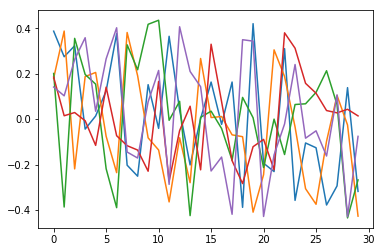

In [60]:
i=2
print cell_types[cell_idxs[-k:]]
cell_idx = cell_idxs[-k:][i]
print cell_types[cell_idx]
# plt.plot(W[cell_types[cell_idx]])
plt.plot(np.squeeze(W.values()).T)
# plt.plot(reduced_binned_spikes[-1,:])

In [4]:
D = np.load('movie_data.npz')
binned_spikes = D['binned_spikes']
stim_array = D['stim_array']


In [11]:
binned_spikes = np.expand_dims(np.loadtxt('binned_spikes_cell_2.txt',delimiter=','),0)
stim_array = np.expand_dims(np.loadtxt('binned_stim_cell_2.txt',delimiter=','),0)

In [22]:
np.savez('state_save',binned_spikes=binned_spikes, stim_array=stim_array, cell_types=cell_types)

Text(0,0.5,'training loss - unique parameters')

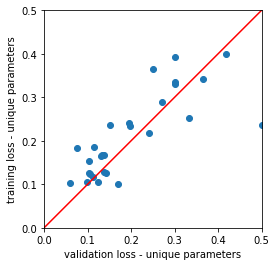

In [54]:
D = np.load('param_nonshared_run1.npz')
pts = [0,0.5]
plt.scatter(val_losses, losses)
plt.plot(pts,pts,'r')
plt.plot
plt.axis('square')
plt.xlim(pts)
plt.ylim(pts)
plt.xlabel('validation loss - unique parameters')
plt.ylabel('training loss - unique parameters')

In [18]:
print models[0].metrics_names

['loss']
